In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

In [67]:
import os

def cleanFilenames(directory):
    for filename in os.listdir(directory):
        filenameold = filename
        filename2 = "_".join(filename.replace(",", " ").replace(":", " ").split(" "))
        os.rename(directory+filenameold, directory+filename2)

In [68]:
import os
import datetime

def cleanContig(directory, filename, output = False):
    
    months = {'February': 2, 'January': 1}
    dateTime = filename.split("_")[6:]
    dateTime = [months[i] if i in months.keys() else i for i in dateTime ]
    date = dateTime[0]+'-'+str(dateTime[1])+'-'+'2019'
    time = dateTime[3]+':'+dateTime[4]
    tag = pd.to_datetime(date + ' ' + time).strftime('%Y-%m-%d %H:%M:%S')
    df = pd.read_csv(directory+filename, header=None)
    
    df = df[0].str.split("_", n=10, expand = True) 
    if output:
        print(filename)
        print(tag)
    df = df.drop([0,1,5,8], axis=1)
    new = df[10].str.split(" ", n=2, expand = True)
    df[10]=new[0]
    df['distance'] = new[1]
    df = df.replace(months)
    #print(df.head())
    df['date'] = df[6].astype('str')+'-'+df[7].astype('str')+'-'+'2019'
    df['time'] = df[9].astype('str')+':'+df[10].astype('str')
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], dayfirst = True)
    df = df.drop([6,7,9,10, 'date', 'time'], axis=1)
    df = df.rename(index=str, columns={2:'WorkshopEd', 3:'Username', 4:'MacroRev'})
    df['distance'] = pd.to_numeric(df['distance'])
    df = df.sort_values(by='datetime').reset_index(drop=True)
    df['Edit']=df.index
    df = df.set_index('datetime')
    df['Edit_norm'] = (df['Edit']-df['Edit'].min())/(df['Edit'].max()-df['Edit'].min())
    df.to_csv(directory+'../CleanContigs/Contig'+tag.strip()+'.csv')
    return tag, df

In [5]:
contigs = dict()
directory = './COLLIAUX/START/ris_bcl+5829-5829/'
#os.mkdir(directory+'../CleanContigs')
for filename in os.listdir(directory):
    tag, df = cleanContig(directory, filename)
    contigs[tag] = df

      2         3  4   6  7   9  10  distance
0  SEW1  COLLIAUX  2  30  1  17  40  0.075632
1  SEW1  COLLIAUX  2  30  1  17  38  0.076092
2  SEW1  COLLIAUX  2  30  1  17  44  0.076092
3  SEW1  COLLIAUX  2  30  1  17  41  0.076782
4  SEW1  COLLIAUX  2  30  1  17  46  0.080000
      2         3  4   6  7   9  10  distance
0  SEW1  COLLIAUX  1  30  1  10  58  0.075362
1  SEW1  COLLIAUX  2  30  1  17  05  0.075362
2  SEW1  COLLIAUX  2  30  1  17  10  0.078977
3  SEW1  COLLIAUX  2  30  1  17  12  0.099277
4  SEW1  COLLIAUX  2  30  1  17  11  0.099277
      2         3  4   6  7   9  10  distance
0  SEW1  COLLIAUX  2  30  1  17  38  0.076142
1  SEW1  COLLIAUX  2  30  1  17  39  0.076142
2  SEW1  COLLIAUX  2  30  1  17  41  0.076834
3  SEW1  COLLIAUX  2  30  1  17  40  0.076834
4  SEW1  COLLIAUX  2  30  1  17  44  0.077065
      2         3  4   6  7   9  10  distance
0  SEW1  COLLIAUX  2  30  1  17  28  0.078802
1  SEW1  COLLIAUX  2  30  1  17  33  0.089627
2  SEW1  COLLIAUX  2  30  1  17  3

      2         3  4   6  7   9  10  distance
0  SEW1  COLLIAUX  2  30  1  17  05  0.071001
1  SEW1  COLLIAUX  1  30  1  10  57  0.071001
2  SEW1  COLLIAUX  1  30  1  10  58  0.071001
3  SEW1  COLLIAUX  2  30  1  17  08  0.075278
4  SEW1  COLLIAUX  2  30  1  17  10  0.081836
      2         3  4   6  7   9  10  distance
0  SEW1  COLLIAUX  2  30  1  17  23  0.071941
1  SEW1  COLLIAUX  2  30  1  17  13  0.086806
2  SEW1  COLLIAUX  2  30  1  17  24  0.100345
3  SEW1  COLLIAUX  2  30  1  17  26  0.110698
4  SEW1  COLLIAUX  2  30  1  17  27  0.116273
      2         3  4   6  7   9  10  distance
0  SEW1  COLLIAUX  2  30  1  17  05  0.065369
1  SEW1  COLLIAUX  2  30  1  17  08  0.074270
2  SEW1  COLLIAUX  2  30  1  17  10  0.080111
3  SEW1  COLLIAUX  2  30  1  17  12  0.100417
4  SEW1  COLLIAUX  2  30  1  17  11  0.100417
      2         3  4   6  7   9  10  distance
0  SEW1  COLLIAUX  2  30  1  17  14  0.085593
1  SEW1  COLLIAUX  2  30  1  17  23  0.088783
2  SEW1  COLLIAUX  2  30  1  17  1

      2         3  4   6  7   9  10  distance
0  SEW1  COLLIAUX  2  30  1  17  04  1.666667
1  SEW1  COLLIAUX  1  30  1  09  40  2.000000
2  SEW1  COLLIAUX  1  30  1  09  39  2.000000
3  SEW1  COLLIAUX  1  30  1  09  45  2.333333
4  SEW1  COLLIAUX  1  30  1  09  46  2.333333
      2         3  4   6  7   9  10  distance
0  SEW1  COLLIAUX  1  30  1  09  44  0.106267
1  SEW1  COLLIAUX  1  30  1  09  45  0.136240
2  SEW1  COLLIAUX  1  30  1  09  46  0.138965
3  SEW1  COLLIAUX  1  30  1  09  48  0.147139
4  SEW1  COLLIAUX  1  30  1  09  49  0.147139
      2         3  4   6  7   9  10  distance
0  SEW1  COLLIAUX  1  30  1  09  45  0.102041
1  SEW1  COLLIAUX  1  30  1  09  46  0.104592
2  SEW1  COLLIAUX  1  30  1  09  48  0.109694
3  SEW1  COLLIAUX  1  30  1  09  49  0.109694
4  SEW1  COLLIAUX  1  30  1  10  17  0.112245
      2         3  4   6  7   9  10  distance
0  SEW1  COLLIAUX  4  31  1  15  35  0.079043
1  SEW1  COLLIAUX  4  31  1  16  56  0.079904
2  SEW1  COLLIAUX  3  31  1  14  4

      2         3  4   6  7   9  10  distance
0  SEW1  COLLIAUX  1  30  1  10  35  0.069948
1  SEW1  COLLIAUX  1  30  1  10  37  0.070318
2  SEW1  COLLIAUX  1  30  1  10  46  0.070688
3  SEW1  COLLIAUX  1  30  1  10  49  0.070688
4  SEW1  COLLIAUX  1  30  1  10  48  0.070688
      2         3  4   6  7   9  10  distance
0  SEW1  COLLIAUX  1  30  1  10  32  0.070382
1  SEW1  COLLIAUX  1  30  1  10  34  0.070789
2  SEW1  COLLIAUX  1  30  1  10  35  0.076485
3  SEW1  COLLIAUX  1  30  1  10  36  0.076485
4  SEW1  COLLIAUX  1  30  1  10  37  0.077299


In [6]:
matrix = pd.DataFrame()
matrix['2019-01-30 17:54:00']= contigs['2019-01-30 17:54:00']['distance']
for key, distance in contigs.items():
    matrix[key] = distance['distance']
matrix = matrix.reindex(sorted(matrix.columns), axis=1)
matrix = matrix.sort_index()
matrix

,2019-01-30 09:39:00,2019-01-30 09:40:00,2019-01-30 09:42:00,2019-01-30 09:43:00,2019-01-30 09:44:00,2019-01-30 09:45:00,2019-01-30 09:46:00,2019-01-30 09:48:00,2019-01-30 09:49:00,2019-01-30 09:51:00,...,2019-01-31 14:47:00,2019-01-31 14:49:00,2019-01-31 14:50:00,2019-01-31 14:51:00,2019-01-31 14:52:00,2019-01-31 14:53:00,2019-01-31 14:54:00,2019-01-31 14:55:00,2019-01-31 15:35:00,2019-01-31 16:56:00
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-30 09:39:00,3.679348,0.602804,1.882175,2.035422,2.237245,2.457077,2.592191,2.840951,2.932056,3.074695,...,4.049940,4.046484,4.045903,4.046471,4.046840,4.046205,4.047777,4.045310,4.049974,4.049751
2019-01-30 09:40:00,0.125000,3.677570,1.480363,1.667575,1.908163,2.074246,2.227766,2.499086,2.599303,2.751524,...,3.949544,3.941075,3.939546,3.939137,3.940101,3.938683,3.940715,3.938117,3.949682,3.950249
2019-01-30 09:42:00,0.135870,0.056075,3.930514,0.384196,0.670918,0.974478,1.199566,1.648995,1.792683,2.042683,...,3.847253,3.840505,3.840637,3.841512,3.841372,3.841063,3.842371,3.842031,3.848703,3.849889
2019-01-30 09:43:00,0.130435,0.056075,0.075529,3.773842,0.336735,0.684455,0.932755,1.404022,1.555749,1.833841,...,3.776649,3.767755,3.767712,3.767990,3.769807,3.768456,3.770532,3.769217,3.777950,3.779207
2019-01-30 09:44:00,0.141304,0.056075,0.078550,0.106267,3.923469,0.387471,0.659436,1.122486,1.292683,1.592988,...,3.727570,3.717988,3.717998,3.718398,3.720529,3.720167,3.721534,3.716326,3.729177,3.730657
2019-01-30 09:45:00,0.141304,0.056075,0.111782,0.136240,0.102041,3.786543,0.342733,0.901280,1.069686,1.393293,...,3.664198,3.650423,3.650442,3.650251,3.650879,3.650686,3.652310,3.647743,3.666323,3.666495
2019-01-30 09:46:00,0.141304,0.056075,0.114804,0.138965,0.104592,0.083527,3.835141,0.670932,0.792683,1.157012,...,3.604271,3.591153,3.590681,3.588694,3.587846,3.587980,3.588143,3.586918,3.606560,3.606451
2019-01-30 09:48:00,0.146739,0.060748,0.120846,0.147139,0.109694,0.176334,0.164859,3.722121,0.214286,0.641768,...,3.512141,3.499741,3.495583,3.494018,3.493644,3.493313,3.494333,3.490303,3.513481,3.513810
2019-01-30 09:49:00,0.146739,0.060748,0.120846,0.147139,0.109694,0.178654,0.167028,0.071298,3.707317,0.629573,...,3.473222,3.463107,3.459726,3.457950,3.456208,3.456661,3.454228,3.449577,3.473983,3.474524


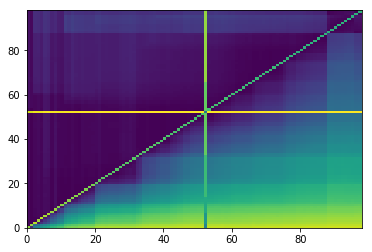

In [7]:
plt.pcolor(matrix)
plt.show()

In [8]:
directory = './COLLIAUX/START/ris_bcl+5829-5829/'
filename = 'Contig.Copy_of_SEW1_COLLIAUX_4_-_31_January__16_56'
tag, df = cleanContig(directory, filename, output=True)
df.head()

Contig.Copy_of_SEW1_COLLIAUX_4_-_31_January__16_56
2019-01-31 16:56:00
      2         3  4   6  7   9  10  distance
0  SEW1  COLLIAUX  4  31  1  15  35  0.080288
1  SEW1  COLLIAUX  3  31  1  14  47  0.093670
2  SEW1  COLLIAUX  3  31  1  14  49  0.151141
3  SEW1  COLLIAUX  3  31  1  14  50  0.179791
4  SEW1  COLLIAUX  3  31  1  14  51  0.192143


,WorkshopEd,Username,MacroRev,distance,Edit
datetime,,,,,
2019-01-30 09:39:00,SEW1,COLLIAUX,1,4.049751,0
2019-01-30 09:40:00,SEW1,COLLIAUX,1,3.950249,1
2019-01-30 09:42:00,SEW1,COLLIAUX,1,3.849889,2
2019-01-30 09:43:00,SEW1,COLLIAUX,1,3.779207,3
2019-01-30 09:44:00,SEW1,COLLIAUX,1,3.730657,4


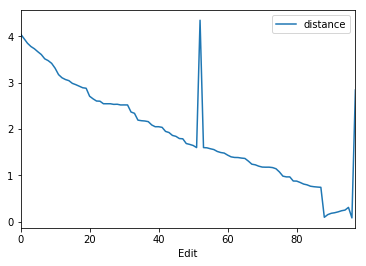

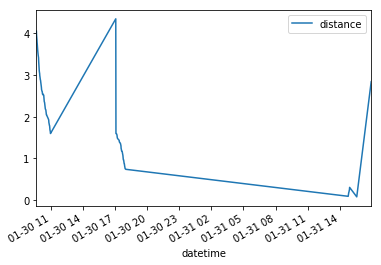

In [9]:
df.plot(x='Edit', y='distance')
df.plot(y='distance', use_index = True)

In [10]:
directory = './VALDANO/START/ris_bcl+3700-3700/'
filename = 'Contig.Copy_of_SEW1_VALDANO_4_-_1_February__13_15'
filename.split("_")
#os.mkdir(directory+'../CleanContigs')
tag, df2 = cleanContig(directory, filename, output=True)
df2.head()

Contig.Copy_of_SEW1_VALDANO_4_-_1_February__13_15
2019-01-02 13:15:00
      2        3  4  6  7   9  10  distance
0  SEW1  VALDANO  4  1  2  11  54  0.085970
1  SEW1  VALDANO  4  1  2  11  51  0.100252
2  SEW1  VALDANO  4  1  2  11  41  0.100252
3  SEW1  VALDANO  4  1  2  11  13  0.129656
4  SEW1  VALDANO  4  1  2  11  12  0.129936


,WorkshopEd,Username,MacroRev,distance,Edit
datetime,,,,,
2019-01-30 09:36:00,SEW1,VALDANO,1,4.427891,0
2019-01-30 09:55:00,SEW1,VALDANO,1,4.223747,1
2019-01-30 09:56:00,SEW1,VALDANO,1,4.142257,2
2019-01-30 09:58:00,SEW1,VALDANO,1,4.029404,3
2019-01-30 09:59:00,SEW1,VALDANO,1,4.050126,4


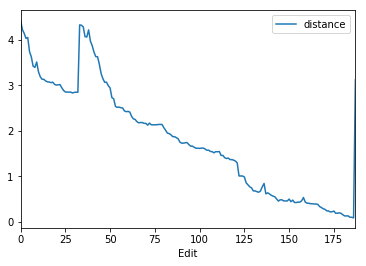

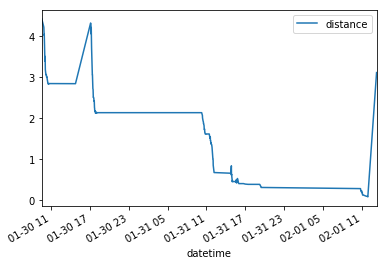

In [11]:
df2.plot(x='Edit', y='distance')
df2.plot(y='distance', use_index=True)

In [98]:
directory = './PACCHETTO_ruggieroDraft/AOUAMEUR/START/'
cleanFilenames(directory)

Copy_of_SEW1_AOUAMEUR_3_-_31_January__10_43
Copy_of_SEW1_AOUAMEUR_3_-_31_January__10_44
Copy_of_SEW1_AOUAMEUR_4_-_31_January__15_42
Copy_of_SEW1_AOUAMEUR_4_-_31_January__15_45
Copy_of_SEW1_AOUAMEUR_4_-_31_January__16_09
Copy_of_SEW1_AOUAMEUR_3_-_31_January__10_21
Copy_of_SEW1_AOUAMEUR_4_-_31_January__15_11
Copy_of_SEW1_AOUAMEUR_4_-_31_January__15_29
Copy_of_SEW1_AOUAMEUR_1_-_30_January__09_49
Copy_of_SEW1_AOUAMEUR_4_-_31_January__15_16
Copy_of_SEW1_AOUAMEUR_3_-_31_January__10_26
Copy_of_SEW1_AOUAMEUR_4_-_31_January__15_20
Copy_of_SEW1_AOUAMEUR_1_-_30_January__09_47
Copy_of_SEW1_AOUAMEUR_4_-_31_January__15_18
Copy_of_SEW1_AOUAMEUR_4_-_31_January__16_00
Copy_of_SEW1_AOUAMEUR_4_-_31_January__15_27
Copy_of_SEW1_AOUAMEUR_4_-_31_January__15_44
Copy_of_SEW1_AOUAMEUR_4_-_31_January__15_43
Copy_of_SEW1_AOUAMEUR_3_-_31_January__10_45
Copy_of_SEW1_AOUAMEUR_4_-_31_January__15_26
Copy_of_SEW1_AOUAMEUR_4_-_31_January__16_01
Copy_of_SEW1_AOUAMEUR_4_-_31_January__16_06
Copy_of_SEW1_AOUAMEUR_4_-_31_Jan

In [12]:
directory = './AOUAMEUR/START/ris_bcl+3700-3700/'
filename = 'Contig.Copy_of_SEW1_AOUAMEUR_4_-_31_January__16_15'
filename.split("_")
#os.mkdir(directory+'../CleanContigs')
tag, df3 = cleanContig(directory, filename, output=False)
df3.head()

      2         3  4   6  7   9  10  distance
0  SEW1  AOUAMEUR  4  31  1  16  14  0.097067
1  SEW1  AOUAMEUR  4  31  1  16  12  0.144542
2  SEW1  AOUAMEUR  4  31  1  16  11  0.230118
3  SEW1  AOUAMEUR  4  31  1  16  09  0.287572
4  SEW1  AOUAMEUR  4  31  1  16  08  0.324463


,WorkshopEd,Username,MacroRev,distance,Edit
datetime,,,,,
2019-01-30 09:43:00,SEW1,AOUAMEUR,1,3.787118,0
2019-01-30 09:47:00,SEW1,AOUAMEUR,1,4.151799,1
2019-01-30 09:49:00,SEW1,AOUAMEUR,1,4.058663,2
2019-01-30 09:50:00,SEW1,AOUAMEUR,1,3.957665,3
2019-01-30 09:51:00,SEW1,AOUAMEUR,1,3.960690,4


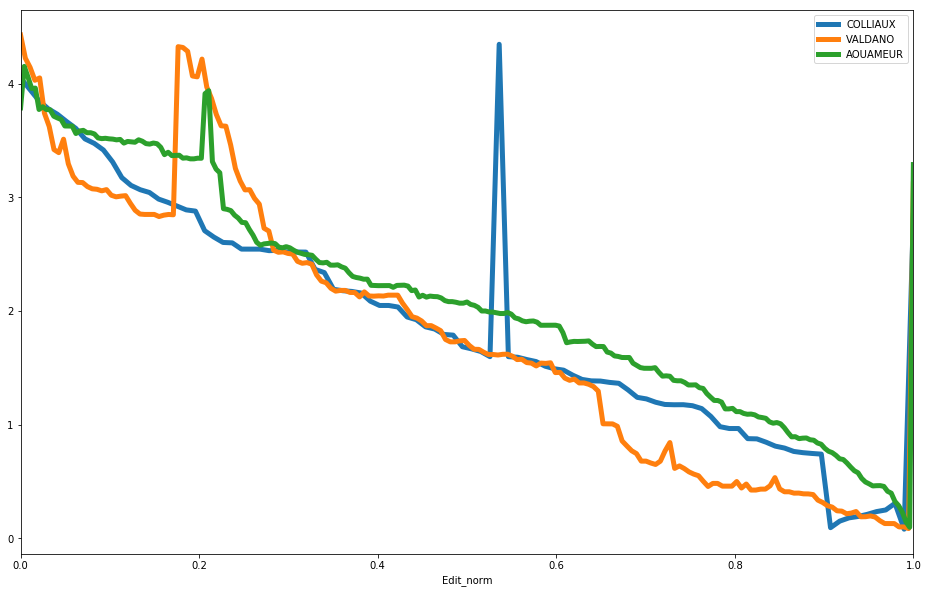

In [13]:
ax = df.plot(x='Edit_norm', y='distance', figsize=(16, 10), linewidth=5)
df2.plot(ax = ax, x='Edit_norm', y='distance', linewidth=5)
df3.plot(ax = ax, x='Edit_norm', y='distance', linewidth=5)
ax.legend(['COLLIAUX', 'VALDANO', 'AOUAMEUR'])

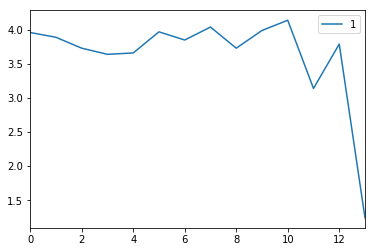

In [30]:
import time
os.system("rm ContigSlinding && bash runningWindow.sh ./AOUAMEUR/START/Copy_of_SEW1_AOUAMEUR_1_-_30_January__10_21")
time.sleep(10)
Sliding = pd.read_csv("ContigSlinding", sep="\t", header=None)
Sliding = Sliding.drop([0], axis=1)
Sliding.plot()
print("VAR(S'): "+str(Sliding[1].var()))
print("Mean(S'): "+str(Sliding[1].mean()))
print("VAR(S'): "+str(np.var(np.diff(Sliding[1]))))

In [44]:
print("VAR(S'): "+str(Sliding[1].var()))
print("Mean(S'): "+str(Sliding[1].mean()))
print("VAR(S'): "+str(np.var(np.diff(Sliding[1]))))

VAR(S'): 0.530532417582
Mean(S'): 3.62642857143
VAR(S'): 0.5944378698224851


In [ ]:
Data=list()
entry = dict("Name":[], "Convergence_df"=[], "LastDraft":[])
for filename in os.listdir(directory):

In [75]:
Data = []
for i, directory in enumerate(next(os.walk('./Data'))[1]):
    Data.append(dict())
    Data[i]['Name']= directory
    path = "./Data/"+directory+"/"
    cleanFilenames(path+"START/")
    os.system("rm -rf ./START && cp -r "+path+"START . && ./bcl3pezza && mv ./START "+path+"START")
    contigs = dict()
    if not os.path.exists(path+'../CleanContigs'):
        os.makedirs(path+'../CleanContigs')
    tag = list()
    filelist = [h for h in os.listdir(path+"START/") if not os.path.isdir(h)]
    for j, filename in enumerate(filelist):
        print(filename)
        tag[j], df = cleanContig(path+"START/ris+10000-10000/", filename)
        contigs[tag[j]] = df
        files.append(filename)
    filetimelist = zip(tag, files)
    lastDraft = sorted(filetimelist, key =lambda x: x[0])[-1]
    df = pd.read_csv(path+'../CleanContigs/Contig'+lastDraft[0].strip()+'.csv')
    Data[i]["Conv_df"] = df
    Data[i]["LastDraft"] = dict()
    os.system("rm ContigSlinding && bash runningWindow.sh "+path+"START/"+lastDraft[1])
    time.sleep(10)
    Sliding = pd.read_csv("ContigSlinding", sep="\t", header=None)
    Sliding = Sliding.drop([0], axis=1)
    Data[i]["LastDraft"]["VarS"] = Sliding[1].var()
    Data[i]["LastDraft"]["MeanS"] = Sliding[1].mean()
    Data[i]["LastDraft"]["VarS'"] = np.var(np.diff(Sliding[1]))
    

Copy_of_SEW1_COLLIAUX_2_-_30_January__17_51


IOError: [Errno 2] File ./Data/COLLIAUX/START/ris+10000-10000/Copy_of_SEW1_COLLIAUX_2_-_30_January__17_51 does not exist: './Data/COLLIAUX/START/ris+10000-10000/Copy_of_SEW1_COLLIAUX_2_-_30_January__17_51'

In [48]:
tag

'2019-01-31 16:15:00'

In [49]:
filename

'Contig.Copy_of_SEW1_AOUAMEUR_4_-_31_January__16_15'